<font color="green">**Sequence to Sequence Model. A single model generates 15 day prediction. After every 15 days new model is generated  using the actual 15 day values.**</font>

In [ ]:
import numpy as np
from random import randint
from numpy import array
from numpy import argmax
from numpy import array_equal
from keras.utils import to_categorical
from keras.models import Model
from keras.layers import Input
from keras.layers import LSTM
from keras.layers import Dense
import pandas_datareader as web
import keras
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

**Get stock data**

In [ ]:
#Get the stock quote 
df = web.DataReader('AAPL', data_source='yahoo', start='2015-01-01', end='2020-11-24')
#df = web.DataReader('AMD', data_source='yahoo', start='2015-01-01', end='2020-11-24')
#df = web.DataReader('TSLA', data_source='yahoo', start='2015-01-01', end='2020-11-24')
#df = web.DataReader('DIS', data_source='yahoo', start='2015-01-01', end='2020-11-24')
#Show the data 
df.head(5)

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2015-01-02,27.860001,26.837500,27.847500,27.332500,212818400.0,24.696352
2015-01-05,27.162500,26.352501,27.072500,26.562500,257142000.0,24.000614
2015-01-06,26.857500,26.157499,26.635000,26.565001,263188400.0,24.002876
2015-01-07,27.049999,26.674999,26.799999,26.937500,160423600.0,24.339447
2015-01-08,28.037500,27.174999,27.307501,27.972500,237458000.0,25.274624


**Initialize hyperparameters**

In [ ]:
keras.backend.clear_session()

layers = [35, 35] # Number of hidden neuros in each layer of the encoder and decoder

learning_rate = 0.01
decay = 0 # Learning rate decay
optimiser = keras.optimizers.Adam(lr=learning_rate, decay=decay) # Other possible optimiser "sgd" (Stochastic Gradient Descent)

num_input_features = 1 # The dimensionality of the input at each time step. In this case a 1D signal.
num_output_features = 1 # The dimensionality of the output at each time step. In this case a 1D signal.
# There is no reason for the input sequence to be of same dimension as the ouput sequence.
# For instance, using 3 input signals: consumer confidence, inflation and house prices to predict the future house prices.

loss = "mse" # Other loss functions are possible, see Keras documentation.

# Regularisation isn't really needed for this application
lambda_regulariser = 0.000001 # Will not be used if regulariser is None
regulariser = None # Possible regulariser: keras.regularizers.l2(lambda_regulariser)

batch_size = 15
steps_per_epoch = 200 # batch_size * steps_per_epoch = total number of training examples
epochs = 15

input_sequence_length = 15 # Length of the sequence used by the encoder
target_sequence_length = 15 # Length of the sequence predicted by the decoder
num_steps_to_predict = 20 # Length to use when testing the model

num_signals = 2 # The number of random sine waves the compose the signal. The more sine waves, the harder the problem.

**Model Encoder neural network**

In [ ]:
# Define an input sequence.
encoder_inputs = keras.layers.Input(shape=(None, num_input_features))

# Create a list of RNN Cells, these are then concatenated into a single layer
# with the RNN layer.
encoder_cells = []
#We use LSTM instead of GRU
for hidden_neurons in layers:
    """encoder_cells.append(keras.layers.GRUCell(hidden_neurons,
                                              kernel_regularizer=regulariser,
                                              recurrent_regularizer=regulariser,
                                              bias_regularizer=regulariser))"""
    encoder_cells.append(keras.layers.LSTMCell(hidden_neurons,
                                              kernel_regularizer=regulariser,
                                              recurrent_regularizer=regulariser,
                                              bias_regularizer=regulariser))
print(encoder_cells[0])
encoder = keras.layers.RNN(encoder_cells, return_state=True)
#encoder = keras.layers.LSTM(encoder_cells, return_state=True)

encoder_outputs_and_states = encoder(encoder_inputs)

# Discard encoder outputs and only keep the states.
# The outputs are of no interest to us, the encoder's
# job is to create a state describing the input sequence.
encoder_states = encoder_outputs_and_states[1:]

**Model Decoder neural network**

In [ ]:
# The decoder input will be set to zero (see random_sine function of the utils module).
# Do not worry about the input size being 1, I will explain that in the next cell.
decoder_inputs = keras.layers.Input(shape=(None, 1))

decoder_cells = []
for hidden_neurons in layers:
    """decoder_cells.append(keras.layers.GRUCell(hidden_neurons,
                                              kernel_regularizer=regulariser,
                                              recurrent_regularizer=regulariser,
                                              bias_regularizer=regulariser))"""
    decoder_cells.append(keras.layers.LSTMCell(hidden_neurons,
                                              kernel_regularizer=regulariser,
                                              recurrent_regularizer=regulariser,
                                              bias_regularizer=regulariser))

decoder = keras.layers.RNN(decoder_cells, return_sequences=True, return_state=True)
#decoder = keras.layers.LSTM(decoder_cells, return_sequences=True, return_state=True)

# Set the initial state of the decoder to be the ouput state of the encoder.
# This is the fundamental part of the encoder-decoder.
decoder_outputs_and_states = decoder(decoder_inputs, initial_state=encoder_states)

# Only select the output of the decoder (not the states)
decoder_outputs = decoder_outputs_and_states[0]

# Apply a dense layer with linear activation to set output to correct dimension
# and scale (tanh is default activation for GRU in Keras, our output sine function can be larger then 1)
decoder_dense = keras.layers.Dense(num_output_features,
                                   activation='linear',
                                   kernel_regularizer=regulariser,
                                   bias_regularizer=regulariser)

decoder_outputs = decoder_dense(decoder_outputs)

**Generate Model**

In [ ]:

# Create a model using the functional API provided by Keras.
# The functional API is great, it gives an amazing amount of freedom in architecture of your NN.
# A read worth your time: https://keras.io/getting-started/functional-api-guide/ 
model = keras.models.Model(inputs=[encoder_inputs, decoder_inputs], outputs=decoder_outputs)
model.compile(optimizer=optimiser, loss=loss)

**Generate batches of 15 day train test windows**

In [ ]:
close_values = df['Close'].values
index = int(len(df)*0.8)
close_values = close_values.tolist()
decoder_values = []
x = []
y = []
for i in range(15,len(close_values)-15):
  decoder_values.append(15*[0])
  x.append(close_values[i-15:i])
  y.append(close_values[i:i+15])

In [ ]:
partition = int(len(x)*0.8)

**Model training and prediction**

In [ ]:
y_pred = []
y_test = []
cnt = 0
for index in range(partition,len(x),15):
  x_train, y_train = np.array(x[:index]), np.array(y[:index])
  decoder_input = np.array(decoder_values[:index])
  model.fit([x_train,decoder_input],y_train, steps_per_epoch=steps_per_epoch, epochs=epochs)

  new_x_test = np.array([y[index]])
  new_decoded = np.array([15*[0]])
  prediction = model.predict([new_x_test,new_decoded])

  y_pred.extend([price[0] for price in prediction.tolist()[0]])
  y_test.extend(y[index+15])

Epoch 1/15
200/200 [==============================] - 2s 11ms/step - loss: 259.1661
Epoch 2/15
200/200 [==============================] - 2s 11ms/step - loss: 87.9094
Epoch 3/15
200/200 [==============================] - 2s 11ms/step - loss: 87.2874
Epoch 4/15
200/200 [==============================] - 2s 11ms/step - loss: 32.0294
Epoch 5/15
200/200 [==============================] - 2s 11ms/step - loss: 10.6071
Epoch 6/15
200/200 [==============================] - 2s 11ms/step - loss: 7.7886
Epoch 7/15
200/200 [==============================] - 2s 11ms/step - loss: 5.9656
Epoch 8/15
200/200 [==============================] - 2s 11ms/step - loss: 5.7318
Epoch 9/15
200/200 [==============================] - 2s 11ms/step - loss: 5.6151
Epoch 10/15
200/200 [==============================] - 2s 11ms/step - loss: 5.9425
Epoch 11/15
200/200 [==============================] - 2s 11ms/step - loss: 6.9542
Epoch 12/15
200/200 [==============================] - 2s 11ms/step - loss: 5.7816
Epoch 1

IndexError: ignored

In [ ]:
x_train.shape

(1449, 15)

In [ ]:
y_train.shape

(1449, 15)

In [ ]:
decoder_input.shape

(1449, 15)

**Prediction visualization**

In [ ]:
training_data = []
training_data.extend(x[0])
for i in range(1,partition):
  training_data.append(x[i][14])
training_data.extend(y[partition-1])

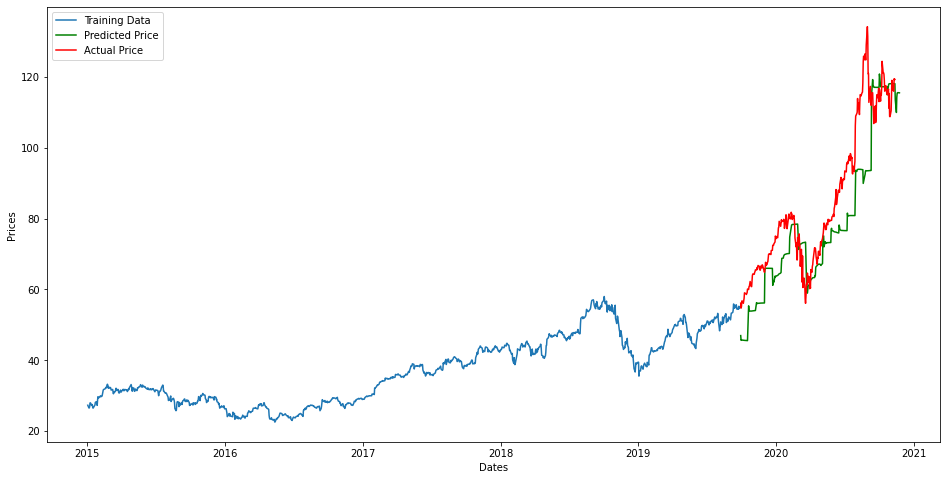

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(df.index[:len(training_data)],training_data, label='Training Data')

plt.plot(df.index[len(training_data):], y_pred[:len(df)-len(training_data)], color='green', label='Predicted Price')
plt.plot(df.index[len(training_data):len(y_test)+len(training_data)], y_test, color='red', label='Actual Price')

#plt.plot(df.index[len(training_data):len(training_data) + len(y_pred)], y_pred, color='green', label='Predicted Price')
#plt.plot(df.index[len(training_data):len(training_data) + len(y_pred)], y_test, color='red', label='Actual Price')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.legend()

**Generate prediction error**

In [ ]:
error = mean_squared_error(y_test, y_pred[:len(y_test)])
#error = mean_absolute_error(x_test[0], y_test_predicted[0])
print(error)

138.75525736615523


In [ ]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
error = mean_absolute_percentage_error(y_test,y_pred[:len(y_test)])
print(error)

10.864489573784269
